##### 作業用ディレクトリの準備
- ローカルのWindows環境で実行する場合は，Git for Windowsを事前にインストールしておく必要があります．

In [1]:
# import os


# # 独自ライブラリ等のダウンロード
# if not os.path.isdir('AI_advanced'):
#     !git clone https://github.com/knakamura1982/AI_advanced.git
# %cd AI_advanced

# # モデルファイルの保存先ディレクトリの作成
# if not os.path.isdir('CGAN_models'):
#     !mkdir CGAN_models

# # 一時ファイルの保存先ディレクトリの作成
# if os.path.exists('temp'):
#     if os.name == 'nt':
#         !Powershell.exe -Command "rm -r -fo temp"
#     else:
#         !rm -fr temp
# !mkdir temp

##### 顔画像データセットCelebAのダウンロード・解凍
- **前回の試行の続きを行いたい場合（再開モードの場合）でも実行が必要です．**
- これは本来のCelebAではなく，その中から10%弱の画像をランダムに抜き出した簡易版です．
- 十数分かかる可能性があります．

In [2]:
# import os
# import torch
# from torchvision import transforms
# from mylib.data_io import CSVBasedDataset


# if not os.path.isfile('./Datasets/tinyCelebA_train_images.pt'):
#     if os.name == 'nt':
#         # ローカルのWindows環境の場合
#         !Powershell.exe -Command "wget https://tus.box.com/shared/static/z7a4pb9qtco6fwspige2tpt2ryhqv9l1.gz -O tinyCelebA.tar.gz"
#         !Powershell.exe -Command "tar -zxf tinyCelebA.tar.gz"
#         !Powershell.exe -Command "rm -fo tinyCelebA.tar.gz"
#     else:
#         # それ以外（Colab環境含む）の場合
#         !wget "https://tus.box.com/shared/static/z7a4pb9qtco6fwspige2tpt2ryhqv9l1.gz" -O tinyCelebA.tar.gz
#         !tar -zxf tinyCelebA.tar.gz
#         !rm -f tinyCelebA.tar.gz
#     dataset = CSVBasedDataset(
#         dirname='./tinyCelebA',
#         filename='./tinyCelebA/image_list.csv',
#         items=[
#             'File Path',
#             [
#                 '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry',
#                 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
#                 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair',
#                 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young'
#             ]
#         ],
#         dtypes=['image', 'float'],
#         img_transform=transforms.CenterCrop((128, 128))
#     )
#     data = [dataset[i] for i in range(len(dataset))]
#     image_tensor = torch.cat([torch.unsqueeze(u, dim=0) for u, v in data], dim=0)
#     label_tensor = torch.cat([torch.unsqueeze(v, dim=0) for u, v in data], dim=0)
#     torch.save(image_tensor, './Datasets/tinyCelebA_train_images.pt')
#     torch.save(label_tensor, './Datasets/tinyCelebA_train_labels.pt')
#     del dataset, data, image_tensor, label_tensor
#     if os.name == 'nt':
#         !Powershell.exe -Command "rm -r -fo tinyCelebA"
#     else:
#         !rm -fr tinyCelebA

##### データセットの場所やバッチサイズなどの定数値の設定

In [3]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
import torch


# 前回の試行の続きを行いたい場合は True にする -> 再開モードになる．
# なお，Colab環境で再開モードを利用する場合は，前回終了時に temp ディレクトリの中身を自分の Google Drive に退避しておき，
# それを改めて /content/AI_advanced/temp 以下にあらかじめ移しておく必要がある．
RESTART_MODE = False


# 使用するデバイス
# GPU を使用しない環境（CPU環境）で実行する場合は DEVICE = 'cpu' とする．
# GPU が複数存在する環境では，'cuda:0', 'cuda:1', 'cuda:2' などのような形で使用するGPUのIDを指定する．
# Google Colab, Paperspace Gradient などで GPU を利用する場合は DEVICE = 'cuda:0' とすれば良いはず．
DEVICE = 'cuda:0'

# 高速化・省メモリ化のために半精度小数を用いた混合精度学習を行うか否か（Trueの場合は行う）
USE_AMP = True
FLOAT_DTYPE = torch.float16 # 混合精度学習を行う場合の半精度小数の型．環境によっては torch.bfloat16 にした方が良好な性能になる（ただしColabのT4 GPU環境ではムリ）．

# 混合精度学習の設定
if DEVICE == 'cpu':
    USE_AMP = False # CPU使用時は強制的に混合精度学習をOFFにする
LOSS_SCALER = torch.amp.grad_scaler.GradScaler(enabled=USE_AMP, device='cuda', init_scale=2**12)
ADAM_EPS = 1e-4 if USE_AMP and (FLOAT_DTYPE == torch.float16) else 1e-8

# 全ての訓練データを一回ずつ使用することを「1エポック」として，何エポック分学習するか
N_EPOCHS = 200

# 学習時のバッチサイズ
BATCH_SIZE = 64

# データセットの存在するフォルダ・ファイル名
DATA_DIR = './Datasets/'
TRAIN_IMAGES_FILE = 'tinyCelebA_train_images.pt'
TRAIN_LABELS_FILE = 'tinyCelebA_train_labels.pt'

# tinyCelebAにおける属性ラベルの名称と番号の対応表
ATTRIBUTE_TABLE = {
    '5_o_Clock_Shadow'  :  0, 'Arched_Eyebrows'     :  1, 'Attractive'       :  2, 'Bags_Under_Eyes' :  3,
    'Bald'              :  4, 'Bangs'               :  5, 'Big_Lips'         :  6, 'Big_Nose'        :  7,
    'Black_Hair'        :  8, 'Blond_Hair'          :  9, 'Blurry'           : 10, 'Brown_Hair'      : 11,
    'Bushy_Eyebrows'    : 12, 'Chubby'              : 13, 'Double_Chin'      : 14, 'Eyeglasses'      : 15,
    'Goatee'            : 16, 'Gray_Hair'           : 17, 'Heavy_Makeup'     : 18, 'High_Cheekbones' : 19,
    'Male'              : 20, 'Mouth_Slightly_Open' : 21, 'Mustache'         : 22, 'Narrow_Eyes'     : 23,
    'No_Beard'          : 24, 'Oval_Face'           : 25, 'Pale_Skin'        : 26, 'Pointy_Nose'     : 27,
    'Receding_Hairline' : 28, 'Rosy_Cheeks'         : 29, 'Sideburns'        : 30, 'Smiling'         : 31,
    'Straight_Hair'     : 32, 'Wavy_Hair'           : 33, 'Wearing_Earrings' : 34, 'Wearing_Hat'     : 35,
    'Wearing_Lipstick'  : 36, 'Wearing_Necklace'    : 37, 'Wearing_Necktie'  : 38, 'Young'           : 39
}

# 取り扱う属性ラベル（上表の中から名称で指定）
TARGET_ATTRIBUTES = ['Straight_Hair', 'Wavy_Hair', 'Male']

# 取り扱う属性ラベルの番号
TARGET_ATTRIBUTES_ID = [ATTRIBUTE_TABLE[a] for a in TARGET_ATTRIBUTES]

# 画像サイズ
H = 128 # 縦幅
W = 128 # 横幅
C = 3 # チャンネル数（カラー画像なら3，グレースケール画像なら1）

# 特徴ベクトルの次元数
N = 128

# 学習結果の保存先フォルダ
MODEL_DIR = './CGAN_models/'

# 学習結果のニューラルネットワークの保存先
MODEL_FILE_G = os.path.join(MODEL_DIR, './face_generator_model.pth') # ジェネレータ
MODEL_FILE_D = os.path.join(MODEL_DIR, './face_discriminator_model.pth') # ディスクリミネータ

# 中断／再開の際に用いる一時ファイル
CHECKPOINT_EPOCH = os.path.join('./temp/', 'checkpoint_epoch.pkl')
CHECKPOINT_GEN_MODEL = os.path.join('./temp/', 'checkpoint_gen_model.pth')
CHECKPOINT_DIS_MODEL = os.path.join('./temp/', 'checkpoint_dis_model.pth')
CHECKPOINT_GEN_OPT = os.path.join('./temp/', 'checkpoint_gen_opt.pth')
CHECKPOINT_DIS_OPT = os.path.join('./temp/', 'checkpoint_dis_opt.pth')

##### ニューラルネットワークモデルの定義

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from mylib.basic_layers import Reshape, MinibatchDiscrimination, DiscriminatorAugmentation


# Pre-act Residual Block
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, sn=False):
        super(ResBlock, self).__init__()
        shortcut_conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        main_conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        main_conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        if sn:
            # spectral normalization を用いる場合（主にディスクリミネータ用）
            self.shortcut = nn.utils.spectral_norm(shortcut_conv)
            self.block1 = nn.Sequential(nn.ReLU(), nn.utils.spectral_norm(main_conv1))
            self.block2 = nn.Sequential(nn.ReLU(), nn.utils.spectral_norm(main_conv2))
        else:
            # バッチ正規化を用いる場合（主にジェネレータ用）
            self.shortcut = shortcut_conv
            self.block1 = nn.Sequential(nn.BatchNorm2d(num_features=in_channels), nn.ReLU(), main_conv1)
            self.block2 = nn.Sequential(nn.BatchNorm2d(num_features=out_channels), nn.ReLU(), main_conv2)
    def forward(self, x):
        s = self.shortcut(x)
        h = self.block1(x)
        h = self.block2(h)
        return h + s


# GANジェネレータ用のアップサンプリング層
class myUpsamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(myUpsamplingBlock, self).__init__()
        self.up = nn.UpsamplingNearest2d(scale_factor=2)
        self.rb = ResBlock(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, sn=False)
    def forward(self, x):
        h = self.up(x)
        return self.rb(h)


# GANディスクリミネータ用のダウンサンプリング層
class myDownsamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(myDownsamplingBlock, self).__init__()
        self.rb = ResBlock(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, sn=True)
        self.down = nn.AvgPool2d(kernel_size=2)
    def forward(self, x):
        h = self.rb(x)
        return self.down(h)


# 顔画像生成ニューラルネットワーク
# CGAN生成器（ジェネレータ）のサンプル
class Generator(nn.Module):

    # C: 出力顔画像のチャンネル数（1または3と仮定）
    # H: 出力顔画像の縦幅（32の倍数と仮定）
    # W: 出力顔画像の横幅（32の倍数と仮定）
    # N: 入力の特徴ベクトル（乱数ベクトル）の次元数
    # K: 属性ラベルの種類数
    def __init__(self, C, H, W, N, K):
        super(Generator, self).__init__()
        self.W = W
        self.H = H

        # 属性ラベル情報を処理する全結合層
        self.embed = nn.Linear(in_features=K, out_features=N) # 属性ラベル情報を特徴ベクトルと同じ N 次元に拡張

        # 属性ラベル情報と特徴ベクトルを連結した後のベクトルをチャンネル数 512, 縦幅 H/32, 横幅 W/32 の特徴マップに変換する層
        self.conv0 = nn.Sequential(
            Reshape(size=(2*N, 1, 1)),
            nn.ConvTranspose2d(in_channels=2*N, out_channels=512, kernel_size=(H//32, W//32), stride=1, padding=0),
        )

        # アップサンプリング層1～5
        # これらを通すことにより特徴マップの縦幅・横幅がそれぞれ 2 倍になる
        # 5つ通すことになるので，最終的には都合 32 倍になる -> ゆえに縦幅 H/32, 横幅 W/32 の特徴マップからスタートする
        self.up1 = myUpsamplingBlock(in_channels=512, out_channels=256)
        self.up2 = myUpsamplingBlock(in_channels=256, out_channels=128)
        self.up3 = myUpsamplingBlock(in_channels=128, out_channels=64)
        self.up4 = myUpsamplingBlock(in_channels=64, out_channels=32)
        self.up5 = myUpsamplingBlock(in_channels=32, out_channels=32)

        # 出力画像生成用の畳込み層
        self.conv5 = nn.Sequential(
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=C, kernel_size=1, stride=1, padding=0),
        )

    def forward(self, z, y):
        y = self.embed(y) # 属性ラベル情報を N 次元に
        h = torch.cat((z, y), dim=1) # 特徴ベクトルと属性ラベル情報を連結 -> トータル256次元に
        h = self.conv0(h) # 256次元の特徴ベクトルをチャンネル数 512, 縦幅 H/32, 横幅 W/32 の特徴マップに変換
        h = self.up1(h)
        h = self.up2(h)
        h = self.up3(h)
        h = self.up4(h)
        h = self.up5(h)
        y = torch.tanh(self.conv5(h))
        return y


# 顔画像が Real か Fake を判定するニューラルネットワーク
# CGAN識別器（ディスクリミネータ）のサンプル
class Discriminator(nn.Module):

    # C: 入力顔画像のチャンネル数（1または3と仮定）
    # H: 入力顔画像の縦幅（32の倍数と仮定）
    # W: 入力顔画像の横幅（32の倍数と仮定）
    # K: 属性ラベルの種類数
    def __init__(self, C, H, W, K):
        super(Discriminator, self).__init__()

        # 訓練データ量の不足を補うためのデータ拡張（Data Augmentation）処理
        self.preprocess = DiscriminatorAugmentation(H, W, p_hflip=0.5, p_vflip=0.4, p_rot=0.4) # 確率0.5で左右反転，確率0.4で上下反転，確率0.4で回転

        # ダウンサンプリング層1～5
        # カーネルサイズ4，ストライド幅2，パディング1の設定なので，これらを通すことにより特徴マップの縦幅・横幅がそれぞれ 1/2 になる
        self.down1 = myDownsamplingBlock(in_channels=C+K, out_channels=32)
        self.down2 = myDownsamplingBlock(in_channels=32, out_channels=64)
        self.down3 = myDownsamplingBlock(in_channels=64, out_channels=128)
        self.down4 = myDownsamplingBlock(in_channels=128, out_channels=256)
        self.down5 = myDownsamplingBlock(in_channels=256, out_channels=256)

        # 平坦化
        self.flat = nn.Flatten()

        # 全結合層1（spectral normalization を使用）
        # ダウンサンプリング層1～5を通すことにより特徴マップの縦幅・横幅は都合 1/32 になっているので，
        # 入力側のパーセプトロン数は 256*(H/32)*(W/32) = H*W/4
        self.fc1 = nn.utils.spectral_norm(nn.Linear(in_features=H*W//4, out_features=256))

        # 全結合層2
        self.fc2 = nn.Linear(in_features=384, out_features=1)

        # Minibatch Discrimination: モード崩壊を回避するための技法の一つ
        self.md = MinibatchDiscrimination(in_features=256, out_features=128)

    def forward(self, x, y):
        # 本来であれば，ディスクリミネータの出力が 0～1 の範囲となるよう，最終層の活性化関数として sigmoid を適用すべきであるが，
        # このサンプルコードでは損失関数側で sigmoid 適用することになるので, ここでは最終層で活性化関数を適用しない
        y = y.reshape(*y.size(), 1, 1).repeat(1, 1, x.size()[2], x.size()[3]) # 属性ラベル情報を画像と同じ形に拡張
        x = self.preprocess(x)
        h = torch.cat((x, y), dim=1) # 画像情報とラベル情報を結合
        h = self.down1(h)
        h = self.down2(h)
        h = self.down3(h)
        h = self.down4(h)
        h = self.down5(h)
        h = self.flat(h)
        h = F.relu(self.fc1(h))
        h = self.md(h) # Minibatch Discrimination
        z = self.fc2(h) # 上記の通り，最終層では活性化関数なし
        return z

##### 訓練データセットの読み込み

In [5]:
import torch
from torch.utils.data import DataLoader
from mylib.data_io import TensorDataset


# テンソルファイルを読み込み, 訓練データセットを用意
# 今回は，全てのデータを学習用に回す
image_tensor = torch.load(os.path.join(DATA_DIR, TRAIN_IMAGES_FILE), weights_only=True)
label_tensor = torch.load(os.path.join(DATA_DIR, TRAIN_LABELS_FILE), weights_only=True)
label_tensor = torch.cat([label_tensor[:, TARGET_ATTRIBUTES_ID[i]:TARGET_ATTRIBUTES_ID[i]+1] for i in range(len(TARGET_ATTRIBUTES_ID))], dim=1)
train_dataset = TensorDataset(tensors=[image_tensor, label_tensor])
train_size = len(train_dataset)

# 訓練データをミニバッチに分けて使用するための「データローダ」を用意
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

##### 学習処理の実行
- CGANの学習は一般に安定せず，最終的なモデルよりも学習途中のモデルの方が優れていることがよくあります
- このため，エポックごとにモデル保存処理を実行し，学習終了後，最良（と思われる）モデルをロードして利用することも多いです
- ただし，これを Google Colab などのクラウド環境で実行するとストレージ使用量の上限を超えてしまう可能性があるので，注意してください

Epoch 1:


100%|██████████| 250/250 [00:22<00:00, 11.19it/s]


generator train loss = 2.055483
discriminator train loss = 0.985675



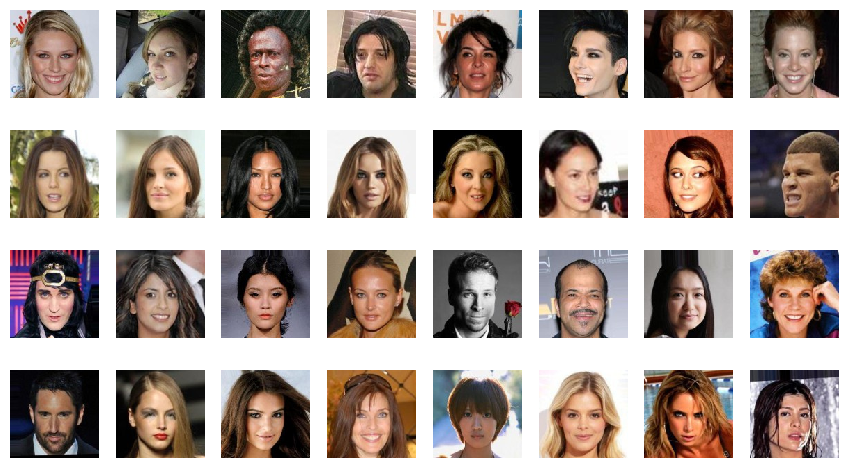

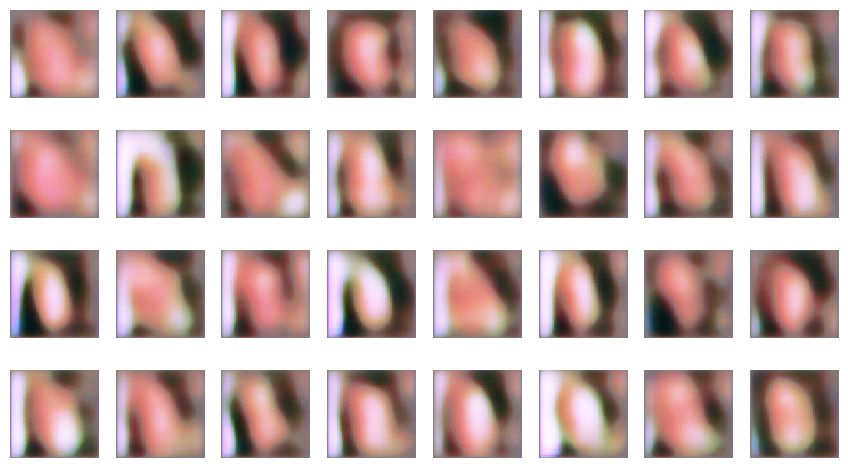

Epoch 2:


100%|██████████| 250/250 [00:21<00:00, 11.82it/s]


generator train loss = 1.662007
discriminator train loss = 1.031226

Epoch 3:


100%|██████████| 250/250 [00:21<00:00, 11.85it/s]


generator train loss = 2.085225
discriminator train loss = 0.936775

Epoch 4:


100%|██████████| 250/250 [00:21<00:00, 11.84it/s]


generator train loss = 1.777337
discriminator train loss = 0.990669

Epoch 5:


100%|██████████| 250/250 [00:21<00:00, 11.86it/s]


generator train loss = 1.891999
discriminator train loss = 0.991972

Epoch 6:


100%|██████████| 250/250 [00:21<00:00, 11.86it/s]


generator train loss = 1.614328
discriminator train loss = 1.073502

Epoch 7:


100%|██████████| 250/250 [00:21<00:00, 11.84it/s]


generator train loss = 1.324254
discriminator train loss = 1.132375

Epoch 8:


100%|██████████| 250/250 [00:21<00:00, 11.88it/s]


generator train loss = 1.272589
discriminator train loss = 1.118274

Epoch 9:


100%|██████████| 250/250 [00:21<00:00, 11.87it/s]


generator train loss = 1.232078
discriminator train loss = 1.151911

Epoch 10:


100%|██████████| 250/250 [00:21<00:00, 11.88it/s]


generator train loss = 1.471444
discriminator train loss = 1.130649

Epoch 11:


100%|██████████| 250/250 [00:21<00:00, 11.83it/s]


generator train loss = 1.417201
discriminator train loss = 1.117675

Epoch 12:


100%|██████████| 250/250 [00:21<00:00, 11.81it/s]


generator train loss = 1.665124
discriminator train loss = 1.082697

Epoch 13:


100%|██████████| 250/250 [00:21<00:00, 11.85it/s]


generator train loss = 1.688585
discriminator train loss = 1.066273

Epoch 14:


100%|██████████| 250/250 [00:21<00:00, 11.87it/s]


generator train loss = 1.493388
discriminator train loss = 1.082855

Epoch 15:


100%|██████████| 250/250 [00:21<00:00, 11.78it/s]


generator train loss = 1.460001
discriminator train loss = 1.113688

Epoch 16:


100%|██████████| 250/250 [00:21<00:00, 11.75it/s]


generator train loss = 1.481790
discriminator train loss = 1.093532

Epoch 17:


100%|██████████| 250/250 [00:21<00:00, 11.55it/s]


generator train loss = 1.459681
discriminator train loss = 1.096095

Epoch 18:


100%|██████████| 250/250 [00:21<00:00, 11.80it/s]


generator train loss = 1.552447
discriminator train loss = 1.063563

Epoch 19:


100%|██████████| 250/250 [00:21<00:00, 11.84it/s]


generator train loss = 1.310408
discriminator train loss = 1.094388

Epoch 20:


100%|██████████| 250/250 [00:21<00:00, 11.85it/s]


generator train loss = 1.617672
discriminator train loss = 1.059279

Epoch 21:


100%|██████████| 250/250 [00:21<00:00, 11.84it/s]


generator train loss = 1.402319
discriminator train loss = 1.109281

Epoch 22:


100%|██████████| 250/250 [00:21<00:00, 11.87it/s]


generator train loss = 1.308659
discriminator train loss = 1.139413

Epoch 23:


100%|██████████| 250/250 [00:21<00:00, 11.88it/s]


generator train loss = 1.238474
discriminator train loss = 1.140377

Epoch 24:


100%|██████████| 250/250 [00:21<00:00, 11.81it/s]


generator train loss = 1.149529
discriminator train loss = 1.126256

Epoch 25:


100%|██████████| 250/250 [00:21<00:00, 11.87it/s]


generator train loss = 1.292220
discriminator train loss = 1.123768

Epoch 26:


100%|██████████| 250/250 [00:21<00:00, 11.83it/s]


generator train loss = 1.359443
discriminator train loss = 1.135216

Epoch 27:


100%|██████████| 250/250 [00:21<00:00, 11.83it/s]


generator train loss = 1.453854
discriminator train loss = 1.111986

Epoch 28:


100%|██████████| 250/250 [00:21<00:00, 11.81it/s]


generator train loss = 1.280257
discriminator train loss = 1.154658

Epoch 29:


100%|██████████| 250/250 [00:21<00:00, 11.82it/s]


generator train loss = 1.266673
discriminator train loss = 1.149571

Epoch 30:


100%|██████████| 250/250 [00:21<00:00, 11.78it/s]


generator train loss = 1.324623
discriminator train loss = 1.116502

Epoch 31:


100%|██████████| 250/250 [00:21<00:00, 11.74it/s]


generator train loss = 8.120138
discriminator train loss = 0.512395

Epoch 32:


100%|██████████| 250/250 [00:21<00:00, 11.80it/s]


generator train loss = 13.242549
discriminator train loss = 0.420935

Epoch 33:


100%|██████████| 250/250 [00:21<00:00, 11.84it/s]


generator train loss = 8.278903
discriminator train loss = 0.478525

Epoch 34:


100%|██████████| 250/250 [00:21<00:00, 11.82it/s]


generator train loss = 4.125862
discriminator train loss = 0.619824

Epoch 35:


100%|██████████| 250/250 [00:21<00:00, 11.82it/s]


generator train loss = 6.053265
discriminator train loss = 0.594402

Epoch 36:


100%|██████████| 250/250 [00:21<00:00, 11.80it/s]


generator train loss = 4.804254
discriminator train loss = 0.677753

Epoch 37:


100%|██████████| 250/250 [00:21<00:00, 11.62it/s]


generator train loss = 3.252694
discriminator train loss = 0.747399

Epoch 38:


100%|██████████| 250/250 [00:21<00:00, 11.80it/s]


generator train loss = 3.234961
discriminator train loss = 0.684104

Epoch 39:


100%|██████████| 250/250 [00:21<00:00, 11.81it/s]


generator train loss = 3.584812
discriminator train loss = 0.735269

Epoch 40:


100%|██████████| 250/250 [00:21<00:00, 11.82it/s]


generator train loss = 3.490897
discriminator train loss = 0.686580

Epoch 41:


100%|██████████| 250/250 [00:21<00:00, 11.78it/s]


generator train loss = 4.375629
discriminator train loss = 0.702000

Epoch 42:


100%|██████████| 250/250 [00:21<00:00, 11.76it/s]


generator train loss = 3.789458
discriminator train loss = 0.671730

Epoch 43:


100%|██████████| 250/250 [00:21<00:00, 11.63it/s]


generator train loss = 3.604403
discriminator train loss = 0.654563

Epoch 44:


100%|██████████| 250/250 [00:21<00:00, 11.66it/s]


generator train loss = 4.062056
discriminator train loss = 0.618926

Epoch 45:


100%|██████████| 250/250 [00:21<00:00, 11.78it/s]


generator train loss = 4.292477
discriminator train loss = 0.580208

Epoch 46:


100%|██████████| 250/250 [00:21<00:00, 11.88it/s]


generator train loss = 3.696197
discriminator train loss = 0.656007

Epoch 47:


100%|██████████| 250/250 [00:21<00:00, 11.81it/s]


generator train loss = 3.548163
discriminator train loss = 0.631976

Epoch 48:


100%|██████████| 250/250 [00:21<00:00, 11.88it/s]


generator train loss = 3.566861
discriminator train loss = 0.630798

Epoch 49:


100%|██████████| 250/250 [00:21<00:00, 11.84it/s]


generator train loss = 3.515201
discriminator train loss = 0.644962

Epoch 50:


100%|██████████| 250/250 [00:21<00:00, 11.79it/s]


generator train loss = 3.465650
discriminator train loss = 0.655319



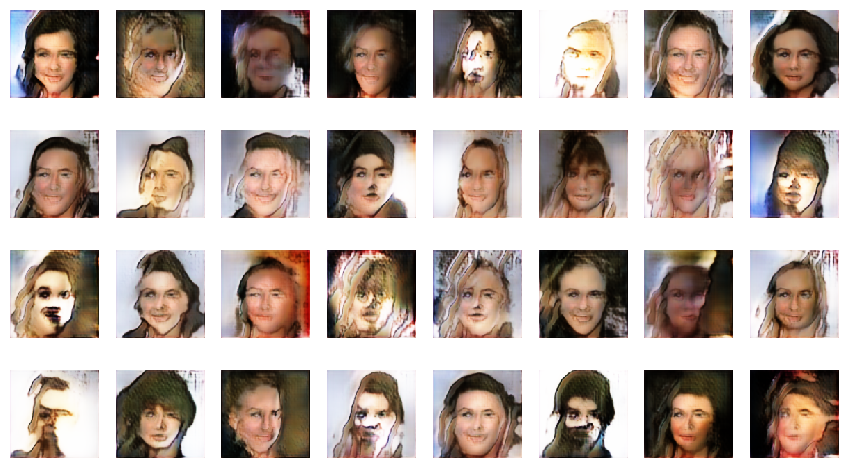

Epoch 51:


100%|██████████| 250/250 [00:21<00:00, 11.80it/s]


generator train loss = 4.219155
discriminator train loss = 0.617359

Epoch 52:


100%|██████████| 250/250 [00:21<00:00, 11.81it/s]


generator train loss = 3.932551
discriminator train loss = 0.589688

Epoch 53:


100%|██████████| 250/250 [00:21<00:00, 11.87it/s]


generator train loss = 3.683508
discriminator train loss = 0.620522

Epoch 54:


100%|██████████| 250/250 [00:21<00:00, 11.81it/s]


generator train loss = 3.442790
discriminator train loss = 0.633305

Epoch 55:


100%|██████████| 250/250 [00:21<00:00, 11.83it/s]


generator train loss = 3.623026
discriminator train loss = 0.632173

Epoch 56:


100%|██████████| 250/250 [00:21<00:00, 11.84it/s]


generator train loss = 3.340576
discriminator train loss = 0.664776

Epoch 57:


100%|██████████| 250/250 [00:21<00:00, 11.84it/s]


generator train loss = 3.769763
discriminator train loss = 0.630690

Epoch 58:


100%|██████████| 250/250 [00:21<00:00, 11.85it/s]


generator train loss = 3.542141
discriminator train loss = 0.647985

Epoch 59:


100%|██████████| 250/250 [00:21<00:00, 11.84it/s]


generator train loss = 4.080783
discriminator train loss = 0.646587

Epoch 60:


100%|██████████| 250/250 [00:21<00:00, 11.87it/s]


generator train loss = 3.754236
discriminator train loss = 0.639132

Epoch 61:


100%|██████████| 250/250 [00:21<00:00, 11.86it/s]


generator train loss = 3.764041
discriminator train loss = 0.653385

Epoch 62:


100%|██████████| 250/250 [00:21<00:00, 11.87it/s]


generator train loss = 3.517112
discriminator train loss = 0.636488

Epoch 63:


100%|██████████| 250/250 [00:21<00:00, 11.83it/s]


generator train loss = 3.713036
discriminator train loss = 0.610612

Epoch 64:


100%|██████████| 250/250 [00:21<00:00, 11.80it/s]


generator train loss = 3.638381
discriminator train loss = 0.621979

Epoch 65:


100%|██████████| 250/250 [00:21<00:00, 11.80it/s]


generator train loss = 3.895532
discriminator train loss = 0.586001

Epoch 66:


100%|██████████| 250/250 [00:21<00:00, 11.86it/s]


generator train loss = 3.724865
discriminator train loss = 0.610641

Epoch 67:


100%|██████████| 250/250 [00:21<00:00, 11.85it/s]


generator train loss = 3.333188
discriminator train loss = 0.646397

Epoch 68:


100%|██████████| 250/250 [00:21<00:00, 11.90it/s]


generator train loss = 3.206794
discriminator train loss = 0.639162

Epoch 69:


100%|██████████| 250/250 [00:21<00:00, 11.86it/s]


generator train loss = 3.609267
discriminator train loss = 0.577866

Epoch 70:


100%|██████████| 250/250 [00:21<00:00, 11.85it/s]


generator train loss = 3.951024
discriminator train loss = 0.589517

Epoch 71:


100%|██████████| 250/250 [00:21<00:00, 11.85it/s]


generator train loss = 3.657041
discriminator train loss = 0.622515

Epoch 72:


100%|██████████| 250/250 [00:21<00:00, 11.85it/s]


generator train loss = 3.546676
discriminator train loss = 0.608922

Epoch 73:


100%|██████████| 250/250 [00:21<00:00, 11.79it/s]


generator train loss = 3.726859
discriminator train loss = 0.607338

Epoch 74:


100%|██████████| 250/250 [00:21<00:00, 11.81it/s]


generator train loss = 3.703568
discriminator train loss = 0.627557

Epoch 75:


100%|██████████| 250/250 [00:21<00:00, 11.81it/s]


generator train loss = 3.740606
discriminator train loss = 0.623415

Epoch 76:


100%|██████████| 250/250 [00:21<00:00, 11.75it/s]


generator train loss = 3.684544
discriminator train loss = 0.594720

Epoch 77:


100%|██████████| 250/250 [00:21<00:00, 11.84it/s]


generator train loss = 3.994869
discriminator train loss = 0.588159

Epoch 78:


100%|██████████| 250/250 [00:21<00:00, 11.81it/s]


generator train loss = 3.614379
discriminator train loss = 0.618540

Epoch 79:


100%|██████████| 250/250 [00:21<00:00, 11.81it/s]


generator train loss = 3.556642
discriminator train loss = 0.575134

Epoch 80:


100%|██████████| 250/250 [00:21<00:00, 11.82it/s]


generator train loss = 4.018520
discriminator train loss = 0.567846

Epoch 81:


100%|██████████| 250/250 [00:21<00:00, 11.79it/s]


generator train loss = 4.225311
discriminator train loss = 0.566657

Epoch 82:


100%|██████████| 250/250 [00:21<00:00, 11.84it/s]


generator train loss = 3.706285
discriminator train loss = 0.614184

Epoch 83:


100%|██████████| 250/250 [00:21<00:00, 11.85it/s]


generator train loss = 3.971667
discriminator train loss = 0.573864

Epoch 84:


100%|██████████| 250/250 [00:21<00:00, 11.88it/s]


generator train loss = 3.712714
discriminator train loss = 0.616683

Epoch 85:


100%|██████████| 250/250 [00:21<00:00, 11.87it/s]


generator train loss = 3.783670
discriminator train loss = 0.579827

Epoch 86:


100%|██████████| 250/250 [00:21<00:00, 11.82it/s]


generator train loss = 3.239848
discriminator train loss = 0.586313

Epoch 87:


100%|██████████| 250/250 [00:21<00:00, 11.85it/s]


generator train loss = 4.108344
discriminator train loss = 0.571077

Epoch 88:


100%|██████████| 250/250 [00:21<00:00, 11.84it/s]


generator train loss = 4.240442
discriminator train loss = 0.568675

Epoch 89:


100%|██████████| 250/250 [00:21<00:00, 11.84it/s]


generator train loss = 3.990034
discriminator train loss = 0.550345

Epoch 90:


100%|██████████| 250/250 [00:21<00:00, 11.83it/s]


generator train loss = 3.986742
discriminator train loss = 0.572902

Epoch 91:


100%|██████████| 250/250 [00:21<00:00, 11.83it/s]


generator train loss = 3.964121
discriminator train loss = 0.598323

Epoch 92:


100%|██████████| 250/250 [00:21<00:00, 11.82it/s]


generator train loss = 4.401118
discriminator train loss = 0.533848

Epoch 93:


100%|██████████| 250/250 [00:21<00:00, 11.83it/s]


generator train loss = 4.365347
discriminator train loss = 0.548566

Epoch 94:


100%|██████████| 250/250 [00:21<00:00, 11.80it/s]


generator train loss = 4.566034
discriminator train loss = 0.553139

Epoch 95:


100%|██████████| 250/250 [00:21<00:00, 11.75it/s]


generator train loss = 3.851984
discriminator train loss = 0.567202

Epoch 96:


100%|██████████| 250/250 [00:21<00:00, 11.81it/s]


generator train loss = 4.431355
discriminator train loss = 0.543217

Epoch 97:


100%|██████████| 250/250 [00:21<00:00, 11.86it/s]


generator train loss = 3.882985
discriminator train loss = 0.570579

Epoch 98:


100%|██████████| 250/250 [00:21<00:00, 11.88it/s]


generator train loss = 4.231597
discriminator train loss = 0.568844

Epoch 99:


100%|██████████| 250/250 [00:21<00:00, 11.87it/s]


generator train loss = 4.559071
discriminator train loss = 0.566768

Epoch 100:


100%|██████████| 250/250 [00:21<00:00, 11.85it/s]


generator train loss = 4.112992
discriminator train loss = 0.572211



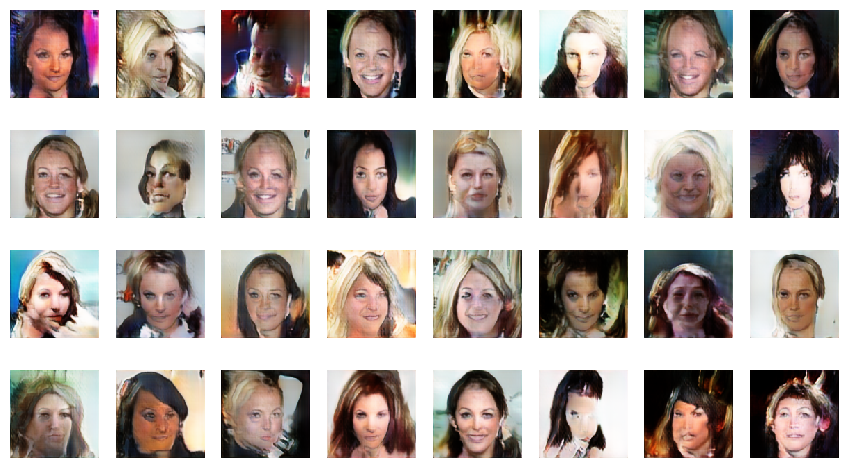

Epoch 101:


100%|██████████| 250/250 [00:21<00:00, 11.65it/s]


generator train loss = 4.210693
discriminator train loss = 0.558716

Epoch 102:


100%|██████████| 250/250 [00:21<00:00, 11.74it/s]


generator train loss = 3.895447
discriminator train loss = 0.552219

Epoch 103:


100%|██████████| 250/250 [00:21<00:00, 11.86it/s]


generator train loss = 4.155195
discriminator train loss = 0.552354

Epoch 104:


100%|██████████| 250/250 [00:21<00:00, 11.82it/s]


generator train loss = 4.240558
discriminator train loss = 0.526621

Epoch 105:


100%|██████████| 250/250 [00:21<00:00, 11.84it/s]


generator train loss = 3.820372
discriminator train loss = 0.563566

Epoch 106:


100%|██████████| 250/250 [00:21<00:00, 11.85it/s]


generator train loss = 4.033992
discriminator train loss = 0.552142

Epoch 107:


100%|██████████| 250/250 [00:21<00:00, 11.84it/s]


generator train loss = 4.388262
discriminator train loss = 0.534852

Epoch 108:


100%|██████████| 250/250 [00:21<00:00, 11.77it/s]


generator train loss = 4.447763
discriminator train loss = 0.547097

Epoch 109:


100%|██████████| 250/250 [00:21<00:00, 11.82it/s]


generator train loss = 4.107534
discriminator train loss = 0.525225

Epoch 110:


100%|██████████| 250/250 [00:21<00:00, 11.80it/s]


generator train loss = 4.570771
discriminator train loss = 0.537371

Epoch 111:


100%|██████████| 250/250 [00:21<00:00, 11.73it/s]


generator train loss = 4.342034
discriminator train loss = 0.545547

Epoch 112:


100%|██████████| 250/250 [00:21<00:00, 11.80it/s]


generator train loss = 4.398714
discriminator train loss = 0.514318

Epoch 113:


100%|██████████| 250/250 [00:21<00:00, 11.65it/s]


generator train loss = 4.346968
discriminator train loss = 0.529256

Epoch 114:


100%|██████████| 250/250 [00:21<00:00, 11.80it/s]


generator train loss = 4.428751
discriminator train loss = 0.508373

Epoch 115:


100%|██████████| 250/250 [00:21<00:00, 11.80it/s]


generator train loss = 3.674381
discriminator train loss = 0.555282

Epoch 116:


100%|██████████| 250/250 [00:21<00:00, 11.86it/s]


generator train loss = 4.531943
discriminator train loss = 0.511893

Epoch 117:


100%|██████████| 250/250 [00:21<00:00, 11.86it/s]


generator train loss = 4.573420
discriminator train loss = 0.518927

Epoch 118:


100%|██████████| 250/250 [00:21<00:00, 11.82it/s]


generator train loss = 4.121285
discriminator train loss = 0.539144

Epoch 119:


100%|██████████| 250/250 [00:21<00:00, 11.87it/s]


generator train loss = 4.394370
discriminator train loss = 0.510299

Epoch 120:


100%|██████████| 250/250 [00:21<00:00, 11.82it/s]


generator train loss = 4.272251
discriminator train loss = 0.526210

Epoch 121:


100%|██████████| 250/250 [00:21<00:00, 11.86it/s]


generator train loss = 4.633303
discriminator train loss = 0.532952

Epoch 122:


100%|██████████| 250/250 [00:21<00:00, 11.83it/s]


generator train loss = 4.491089
discriminator train loss = 0.513597

Epoch 123:


100%|██████████| 250/250 [00:21<00:00, 11.86it/s]


generator train loss = 4.626357
discriminator train loss = 0.498205

Epoch 124:


100%|██████████| 250/250 [00:21<00:00, 11.83it/s]


generator train loss = 4.520119
discriminator train loss = 0.509559

Epoch 125:


100%|██████████| 250/250 [00:21<00:00, 11.88it/s]


generator train loss = 4.559755
discriminator train loss = 0.523207

Epoch 126:


100%|██████████| 250/250 [00:21<00:00, 11.85it/s]


generator train loss = 4.569238
discriminator train loss = 0.503099

Epoch 127:


100%|██████████| 250/250 [00:21<00:00, 11.83it/s]


generator train loss = 4.342901
discriminator train loss = 0.554732

Epoch 128:


100%|██████████| 250/250 [00:21<00:00, 11.86it/s]


generator train loss = 4.389994
discriminator train loss = 0.503942

Epoch 129:


100%|██████████| 250/250 [00:21<00:00, 11.80it/s]


generator train loss = 4.712775
discriminator train loss = 0.520028

Epoch 130:


100%|██████████| 250/250 [00:21<00:00, 11.81it/s]


generator train loss = 4.606185
discriminator train loss = 0.504930

Epoch 131:


100%|██████████| 250/250 [00:21<00:00, 11.78it/s]


generator train loss = 4.265892
discriminator train loss = 0.514173

Epoch 132:


100%|██████████| 250/250 [00:21<00:00, 11.75it/s]


generator train loss = 4.814308
discriminator train loss = 0.494613

Epoch 133:


100%|██████████| 250/250 [00:21<00:00, 11.75it/s]


generator train loss = 4.601984
discriminator train loss = 0.500756

Epoch 134:


100%|██████████| 250/250 [00:21<00:00, 11.73it/s]


generator train loss = 4.298871
discriminator train loss = 0.511936

Epoch 135:


100%|██████████| 250/250 [00:21<00:00, 11.85it/s]


generator train loss = 4.321453
discriminator train loss = 0.534851

Epoch 136:


100%|██████████| 250/250 [00:21<00:00, 11.85it/s]


generator train loss = 4.326879
discriminator train loss = 0.532691

Epoch 137:


100%|██████████| 250/250 [00:21<00:00, 11.69it/s]


generator train loss = 4.535342
discriminator train loss = 0.514701

Epoch 138:


100%|██████████| 250/250 [00:21<00:00, 11.74it/s]


generator train loss = 5.129109
discriminator train loss = 0.457280

Epoch 139:


100%|██████████| 250/250 [00:21<00:00, 11.60it/s]


generator train loss = 3.950255
discriminator train loss = 0.545319

Epoch 140:


100%|██████████| 250/250 [00:21<00:00, 11.75it/s]


generator train loss = 5.162727
discriminator train loss = 0.475658

Epoch 141:


100%|██████████| 250/250 [00:21<00:00, 11.83it/s]


generator train loss = 4.439401
discriminator train loss = 0.511293

Epoch 142:


100%|██████████| 250/250 [00:21<00:00, 11.77it/s]


generator train loss = 4.528342
discriminator train loss = 0.496433

Epoch 143:


100%|██████████| 250/250 [00:21<00:00, 11.69it/s]


generator train loss = 4.329078
discriminator train loss = 0.505718

Epoch 144:


100%|██████████| 250/250 [00:21<00:00, 11.70it/s]


generator train loss = 4.377000
discriminator train loss = 0.520736

Epoch 145:


100%|██████████| 250/250 [00:21<00:00, 11.83it/s]


generator train loss = 4.630195
discriminator train loss = 0.500298

Epoch 146:


100%|██████████| 250/250 [00:21<00:00, 11.65it/s]


generator train loss = 4.672161
discriminator train loss = 0.484642

Epoch 147:


100%|██████████| 250/250 [00:21<00:00, 11.59it/s]


generator train loss = 5.135341
discriminator train loss = 0.473610

Epoch 148:


100%|██████████| 250/250 [00:21<00:00, 11.61it/s]


generator train loss = 4.474530
discriminator train loss = 0.510491

Epoch 149:


100%|██████████| 250/250 [00:21<00:00, 11.70it/s]


generator train loss = 4.401962
discriminator train loss = 0.502195

Epoch 150:


100%|██████████| 250/250 [00:21<00:00, 11.74it/s]


generator train loss = 5.215829
discriminator train loss = 0.471255



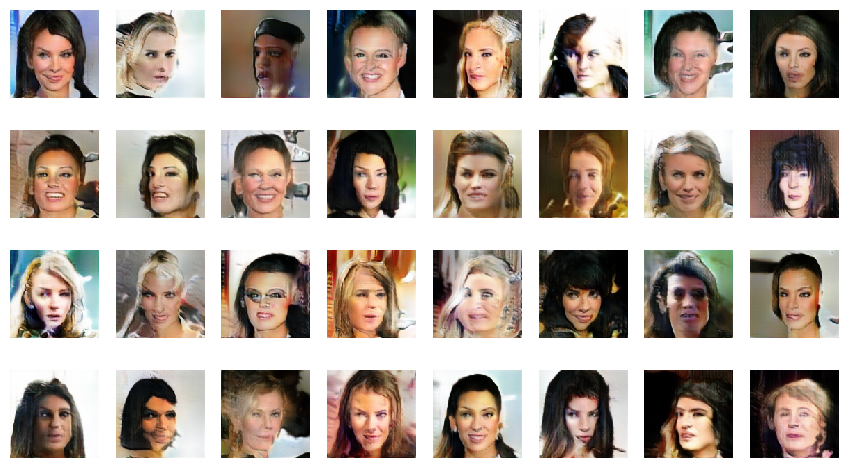

Epoch 151:


100%|██████████| 250/250 [00:21<00:00, 11.79it/s]


generator train loss = 4.989000
discriminator train loss = 0.482247

Epoch 152:


100%|██████████| 250/250 [00:21<00:00, 11.77it/s]


generator train loss = 5.179950
discriminator train loss = 0.474648

Epoch 153:


100%|██████████| 250/250 [00:21<00:00, 11.68it/s]


generator train loss = 4.147854
discriminator train loss = 0.525539

Epoch 154:


100%|██████████| 250/250 [00:21<00:00, 11.73it/s]


generator train loss = 4.683107
discriminator train loss = 0.498915

Epoch 155:


100%|██████████| 250/250 [00:21<00:00, 11.76it/s]


generator train loss = 4.818001
discriminator train loss = 0.500916

Epoch 156:


100%|██████████| 250/250 [00:21<00:00, 11.83it/s]


generator train loss = 4.341001
discriminator train loss = 0.504518

Epoch 157:


100%|██████████| 250/250 [00:21<00:00, 11.83it/s]


generator train loss = 4.443555
discriminator train loss = 0.496310

Epoch 158:


100%|██████████| 250/250 [00:21<00:00, 11.85it/s]


generator train loss = 4.369010
discriminator train loss = 0.509429

Epoch 159:


100%|██████████| 250/250 [00:21<00:00, 11.84it/s]


generator train loss = 4.586546
discriminator train loss = 0.492514

Epoch 160:


100%|██████████| 250/250 [00:21<00:00, 11.85it/s]


generator train loss = 4.929401
discriminator train loss = 0.447978

Epoch 161:


100%|██████████| 250/250 [00:21<00:00, 11.85it/s]


generator train loss = 5.016302
discriminator train loss = 0.459787

Epoch 162:


100%|██████████| 250/250 [00:21<00:00, 11.85it/s]


generator train loss = 5.067386
discriminator train loss = 0.485752

Epoch 163:


100%|██████████| 250/250 [00:21<00:00, 11.86it/s]


generator train loss = 5.517050
discriminator train loss = 0.447108

Epoch 164:


100%|██████████| 250/250 [00:21<00:00, 11.82it/s]


generator train loss = 4.647866
discriminator train loss = 0.510608

Epoch 165:


100%|██████████| 250/250 [00:21<00:00, 11.84it/s]


generator train loss = 4.394530
discriminator train loss = 0.504532

Epoch 166:


100%|██████████| 250/250 [00:21<00:00, 11.82it/s]


generator train loss = 4.883178
discriminator train loss = 0.498754

Epoch 167:


100%|██████████| 250/250 [00:21<00:00, 11.80it/s]


generator train loss = 4.279471
discriminator train loss = 0.520581

Epoch 168:


100%|██████████| 250/250 [00:21<00:00, 11.82it/s]


generator train loss = 4.976052
discriminator train loss = 0.493302

Epoch 169:


100%|██████████| 250/250 [00:21<00:00, 11.82it/s]


generator train loss = 4.606421
discriminator train loss = 0.475337

Epoch 170:


100%|██████████| 250/250 [00:21<00:00, 11.82it/s]


generator train loss = 4.863121
discriminator train loss = 0.473414

Epoch 171:


100%|██████████| 250/250 [00:21<00:00, 11.74it/s]


generator train loss = 4.529507
discriminator train loss = 0.490879

Epoch 172:


100%|██████████| 250/250 [00:21<00:00, 11.82it/s]


generator train loss = 5.310710
discriminator train loss = 0.444450

Epoch 173:


100%|██████████| 250/250 [00:21<00:00, 11.79it/s]


generator train loss = 5.040965
discriminator train loss = 0.475348

Epoch 174:


100%|██████████| 250/250 [00:21<00:00, 11.73it/s]


generator train loss = 4.605889
discriminator train loss = 0.489103

Epoch 175:


100%|██████████| 250/250 [00:21<00:00, 11.73it/s]


generator train loss = 4.420129
discriminator train loss = 0.482635

Epoch 176:


100%|██████████| 250/250 [00:21<00:00, 11.80it/s]


generator train loss = 4.945825
discriminator train loss = 0.476248

Epoch 177:


100%|██████████| 250/250 [00:21<00:00, 11.83it/s]


generator train loss = 5.725095
discriminator train loss = 0.444086

Epoch 178:


100%|██████████| 250/250 [00:21<00:00, 11.89it/s]


generator train loss = 5.014127
discriminator train loss = 0.479770

Epoch 179:


100%|██████████| 250/250 [00:21<00:00, 11.84it/s]


generator train loss = 4.943184
discriminator train loss = 0.473987

Epoch 180:


100%|██████████| 250/250 [00:21<00:00, 11.84it/s]


generator train loss = 5.291034
discriminator train loss = 0.465647

Epoch 181:


100%|██████████| 250/250 [00:21<00:00, 11.84it/s]


generator train loss = 5.345452
discriminator train loss = 0.433254

Epoch 182:


100%|██████████| 250/250 [00:21<00:00, 11.90it/s]


generator train loss = 5.241005
discriminator train loss = 0.454073

Epoch 183:


100%|██████████| 250/250 [00:21<00:00, 11.85it/s]


generator train loss = 4.753902
discriminator train loss = 0.496211

Epoch 184:


100%|██████████| 250/250 [00:21<00:00, 11.88it/s]


generator train loss = 5.165650
discriminator train loss = 0.460183

Epoch 185:


100%|██████████| 250/250 [00:21<00:00, 11.86it/s]


generator train loss = 5.227213
discriminator train loss = 0.447620

Epoch 186:


100%|██████████| 250/250 [00:21<00:00, 11.85it/s]


generator train loss = 4.811436
discriminator train loss = 0.468727

Epoch 187:


100%|██████████| 250/250 [00:21<00:00, 11.80it/s]


generator train loss = 4.794179
discriminator train loss = 0.485125

Epoch 188:


100%|██████████| 250/250 [00:21<00:00, 11.82it/s]


generator train loss = 5.168546
discriminator train loss = 0.459133

Epoch 189:


100%|██████████| 250/250 [00:21<00:00, 11.88it/s]


generator train loss = 5.248425
discriminator train loss = 0.473051

Epoch 190:


100%|██████████| 250/250 [00:21<00:00, 11.83it/s]


generator train loss = 4.929439
discriminator train loss = 0.467149

Epoch 191:


100%|██████████| 250/250 [00:21<00:00, 11.77it/s]


generator train loss = 4.895046
discriminator train loss = 0.485149

Epoch 192:


100%|██████████| 250/250 [00:21<00:00, 11.77it/s]


generator train loss = 5.029595
discriminator train loss = 0.473850

Epoch 193:


100%|██████████| 250/250 [00:21<00:00, 11.78it/s]


generator train loss = 5.614600
discriminator train loss = 0.428030

Epoch 194:


100%|██████████| 250/250 [00:21<00:00, 11.82it/s]


generator train loss = 5.806513
discriminator train loss = 0.431490

Epoch 195:


100%|██████████| 250/250 [00:21<00:00, 11.78it/s]


generator train loss = 5.233794
discriminator train loss = 0.434398

Epoch 196:


100%|██████████| 250/250 [00:21<00:00, 11.77it/s]


generator train loss = 4.939598
discriminator train loss = 0.482005

Epoch 197:


100%|██████████| 250/250 [00:21<00:00, 11.76it/s]


generator train loss = 4.879374
discriminator train loss = 0.484558

Epoch 198:


100%|██████████| 250/250 [00:21<00:00, 11.79it/s]


generator train loss = 4.973109
discriminator train loss = 0.441503

Epoch 199:


100%|██████████| 250/250 [00:21<00:00, 11.83it/s]


generator train loss = 5.182409
discriminator train loss = 0.451640

Epoch 200:


100%|██████████| 250/250 [00:21<00:00, 11.84it/s]


generator train loss = 5.662087
discriminator train loss = 0.437911



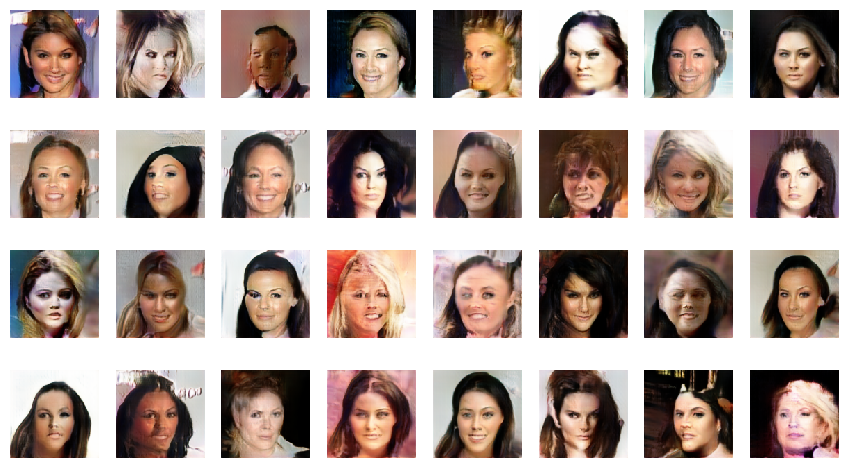

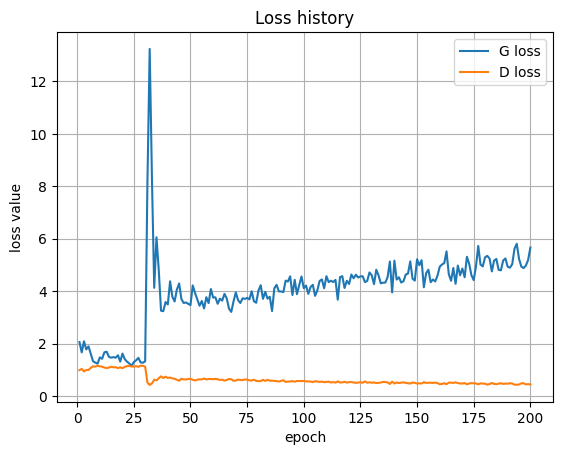

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from mylib.loss_functions import GANLoss
from mylib.visualizers import LossVisualizer
from mylib.data_io import show_images, to_sigmoid_image, to_tanh_image, autosaved_model_name
from mylib.utility import save_checkpoint, load_checkpoint


# 何エポックに1回の割合で学習経過を表示するか（モデル保存処理もこれと同じ頻度で実行）
INTERVAL_FOR_SHOWING_PROGRESS = 50

# spectral normalization の使用によりディスクリミネータが弱体化するので，ジェネレータの更新回数を減らすことが望ましいらしいが，実際にはなんとも言い難い
# ここでは，ジェネレータを5回に1回の割合で更新することにする
N_DIS = 5 # この値を 1 にすれば，ジェネレータも毎回更新されるようになる


# エポック番号
INIT_EPOCH = 0 # 初期値
LAST_EPOCH = INIT_EPOCH + N_EPOCHS # 最終値

# ニューラルネットワークの作成
gen_model = Generator(C=C, H=H, W=W, N=N, K=len(TARGET_ATTRIBUTES)).to(DEVICE)
dis_model = Discriminator(C=C, H=H, W=W, K=len(TARGET_ATTRIBUTES)).to(DEVICE)

# 最適化アルゴリズムの指定（ここでは SGD でなく Adam を使用）
gen_optimizer = optim.Adam(gen_model.parameters(), lr=0.0002, betas=(0.5, 0.999), eps=ADAM_EPS)
dis_optimizer = optim.Adam(dis_model.parameters(), lr=0.0002, betas=(0.5, 0.999), eps=ADAM_EPS)

# 再開モードの場合は，前回チェックポイントから情報をロードして学習再開
if RESTART_MODE:
    INIT_EPOCH, LAST_EPOCH, gen_model, gen_optimizer = load_checkpoint(CHECKPOINT_EPOCH, CHECKPOINT_GEN_MODEL, CHECKPOINT_GEN_OPT, N_EPOCHS, gen_model, gen_optimizer)
    _, _, dis_model, dis_optimizer = load_checkpoint(CHECKPOINT_EPOCH, CHECKPOINT_DIS_MODEL, CHECKPOINT_DIS_OPT, N_EPOCHS, dis_model, dis_optimizer)
    print('')

# 損失関数
loss_func = GANLoss(label_smoothing=True)

# 検証の際に使用する乱数ベクトルおよび属性ラベル情報を用意
Z_valid = torch.randn(BATCH_SIZE, N).to(DEVICE) # 検証用乱数ベクトル
L_valid = torch.zeros(BATCH_SIZE, len(TARGET_ATTRIBUTES)).to(DEVICE) # 検証用属性ラベル情報

# 損失関数値を記録する準備
loss_viz = LossVisualizer(['G loss', 'D loss'], init_epoch=INIT_EPOCH)

# 勾配降下法による繰り返し学習
for epoch in range(INIT_EPOCH, LAST_EPOCH):

    print('Epoch {0}:'.format(epoch + 1))

    # 学習
    gen_model.train()
    dis_model.train()
    sum_gen_loss = 0
    sum_dis_loss = 0
    n_iter = 1 # 1エポック内でのループ回数を記録する変数（ジェネレータの更新回数を制御するために使用）
    for X, L in tqdm(train_dataloader):
        for param in gen_model.parameters():
            param.grad = None
        for param in dis_model.parameters():
            param.grad = None
        L = L.to(DEVICE) # 属性ラベル情報
        Z = torch.randn(len(X), N).to(DEVICE) # 乱数ベクトルを用意
        real = to_tanh_image(X).to(DEVICE) # Real画像を用意（to_tanh_image 関数を用い，画素値の範囲が -1〜1 となるように調整しておく）
        with torch.amp.autocast_mode.autocast(enabled=USE_AMP, device_type='cuda', dtype=FLOAT_DTYPE):
            fake = gen_model(Z, L) # Fake画像を生成（2行上で用意した Z から生成）
            fake_cpy = fake.detach() # Fake画像のコピーを用意しておく
            ### ジェネレータの学習 ###
            if n_iter % N_DIS == 0:
                Y_fake = dis_model(fake, L) # Fake画像を識別
                gen_loss = loss_func.G_loss(Y_fake)
                LOSS_SCALER.scale(gen_loss).backward()
                LOSS_SCALER.step(gen_optimizer)
                LOSS_SCALER.update()
                sum_gen_loss += float(gen_loss) * len(X)
            ### ディスクリミネータの学習 ###
            for param in dis_model.parameters():
                param.grad = None # ジェネレータの学習時の計算した勾配を一旦リセット
            Y_real = dis_model(real, L) # Real画像を識別
            Y_fake = dis_model(fake_cpy, L) # Fake画像を識別（コピー変数の方を使用）
            dis_loss = loss_func.D_loss(Y_fake, as_real=False) + loss_func.D_loss(Y_real, as_real=True)
            LOSS_SCALER.scale(dis_loss).backward()
            LOSS_SCALER.step(dis_optimizer)
            LOSS_SCALER.update()
            sum_dis_loss += float(dis_loss) * len(X)
        n_iter += 1
    avg_gen_loss = sum_gen_loss * N_DIS / train_size
    avg_dis_loss = sum_dis_loss / train_size
    loss_viz.add_value('G loss', avg_gen_loss) # 訓練データに対する損失関数の値を記録
    loss_viz.add_value('D loss', avg_dis_loss) # 同上
    print('generator train loss = {0:.6f}'.format(avg_gen_loss))
    print('discriminator train loss = {0:.6f}'.format(avg_dis_loss))
    print('')

    # 検証（学習経過の表示，モデル自動保存）
    if epoch == 0 or (epoch + 1) % INTERVAL_FOR_SHOWING_PROGRESS == 0:
        gen_model.eval()
        dis_model.eval()
        if epoch == 0:
            real = to_sigmoid_image(real) # to_sigmoid_image 関数を用い，画素値が 0〜1 の範囲となるように調整する
            show_images(real.to('cpu').detach(), num=32, num_per_row=8, title='real images', save_fig=False, save_dir=MODEL_DIR)
        with torch.inference_mode():
            fake = gen_model(Z_valid, L_valid) # 事前に用意しておいた検証用乱数と属性ラベル情報からFake画像を生成
            #fake = gen_model(torch.randn(BATCH_SIZE, N).to(DEVICE), torch.zeros(BATCH_SIZE, len(TARGET_ATTRIBUTES)).to(DEVICE)) # エポックごとに異なる乱数を使用する場合はこのようにする
        fake = to_sigmoid_image(fake) # to_sigmoid_image 関数を用い，画素値が 0〜1 の範囲となるように調整する
        show_images(fake.to('cpu').detach(), num=32, num_per_row=8, title='epoch {0}'.format(epoch + 1), save_fig=False, save_dir=MODEL_DIR)
        torch.save(gen_model.state_dict(), autosaved_model_name(MODEL_FILE_G, epoch + 1)) # 学習途中のモデルを保存したい場合はこのようにする

    # 現在の学習状態を一時ファイル（チェックポイント）に保存
    save_checkpoint(CHECKPOINT_EPOCH, CHECKPOINT_GEN_MODEL, CHECKPOINT_GEN_OPT, epoch+1, gen_model, gen_optimizer)
    save_checkpoint(CHECKPOINT_EPOCH, CHECKPOINT_DIS_MODEL, CHECKPOINT_DIS_OPT, epoch+1, dis_model, dis_optimizer)

# 学習結果のニューラルネットワークモデルをファイルに保存
gen_model = gen_model.to('cpu')
dis_model = dis_model.to('cpu')
torch.save(gen_model.state_dict(), MODEL_FILE_G)
#torch.save(dis_model.state_dict(), MODEL_FILE_D) # ディスクリミネータも保存したい場合はこのようにする

# 損失関数の記録をファイルに保存
loss_viz.save(v_file=os.path.join(MODEL_DIR, 'loss_graph.png'), h_file=os.path.join(MODEL_DIR, 'loss_history.csv'))

##### 学習済みニューラルネットワークモデルのロード

In [7]:
import torch


# ニューラルネットワークモデルとその学習済みパラメータをファイルからロード
gen_model = Generator(C=C, H=H, W=W, N=N, K=len(TARGET_ATTRIBUTES))
gen_model.load_state_dict(torch.load(MODEL_FILE_G, weights_only=True))
#gen_model.load_state_dict(torch.load(autosaved_model_name(MODEL_FILE_G, 90), weights_only=True)) # 例えば90エポック目のモデルをロードしたい場合は，このようにする

<All keys matched successfully>

##### テスト処理1
- 正規分布に従って複数の乱数ベクトルをランダムサンプリングし，それをデコーダに通して画像を生成．属性ラベルは固定値で指定

属性ラベル 1: [1, 0, 0]


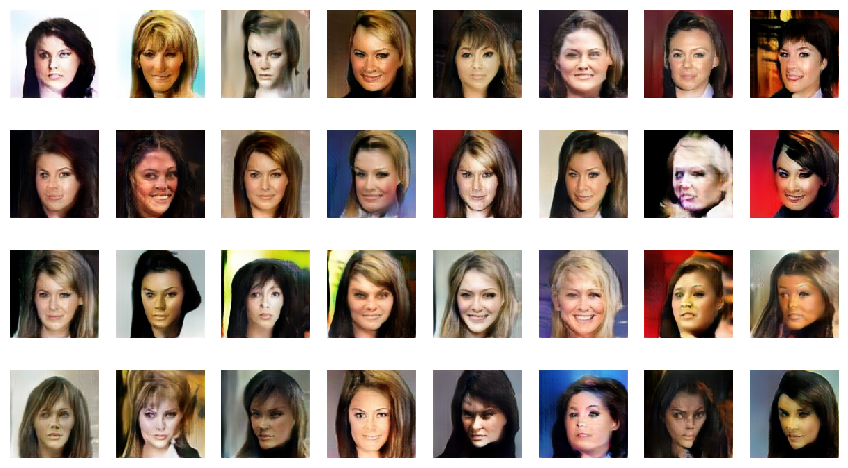

属性ラベル 2: [1, 0, 0]


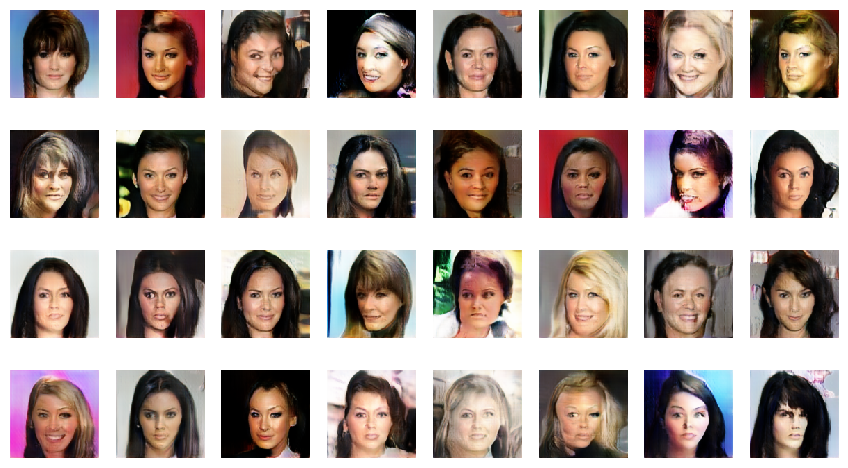

属性ラベル 3: [0, 1, 1]


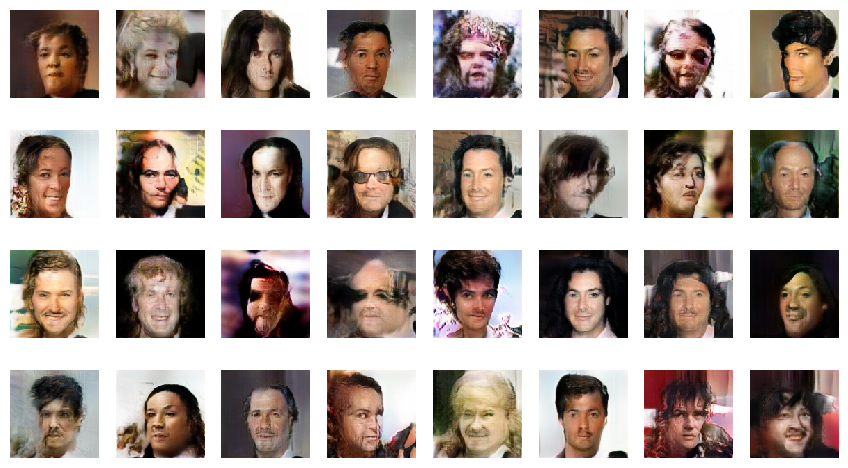

属性ラベル 4: [0, 1, 1]


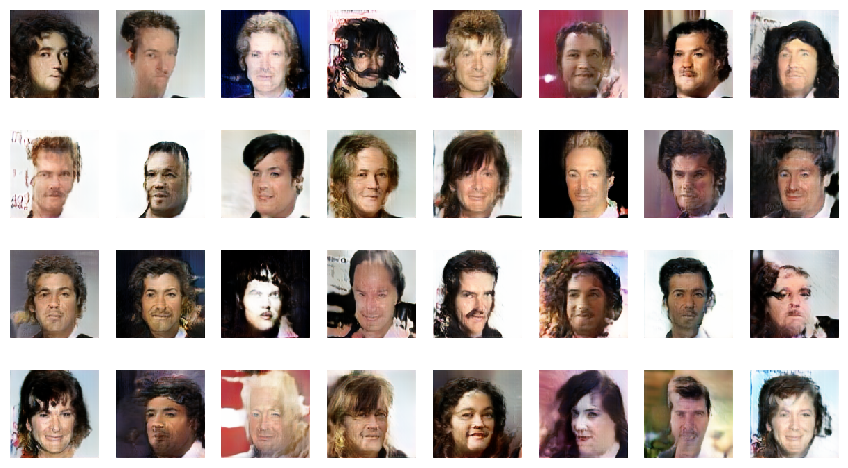

In [8]:
import torch
from mylib.data_io import show_images, to_sigmoid_image


gen_model = gen_model.to(DEVICE)
gen_model.eval()

# 生成する画像の枚数
n_gen = 32

# 属性ラベルの指定値
attribute_list = [
    [1, 0, 0],  # attributes1
    [1, 0, 0],  # attributes2
    [0, 1, 1],  # attributes3
    [0, 1, 1],  # attributes4
]

# ループで各属性ラベルごとに画像生成
for i, attributes in enumerate(attribute_list, start=1):
    print(f"属性ラベル {i}: {attributes}")
    # 標準正規分布から乱数を生成
    Z = torch.randn((n_gen, N)).to(DEVICE)    # 属性ラベルを作成
    L = torch.tensor([attributes], dtype=torch.float32).repeat((n_gen, 1)).to(DEVICE)    # 画像生成と表示
    with torch.inference_mode():
        Y = gen_model(Z, L)
        Y = to_sigmoid_image(Y)
        show_images(
            Y.to('cpu').detach(),
            num=n_gen,
            num_per_row=8,
            title=f'CGAN_sample_generated_case{i}',
            save_fig=True
        ) 

##### テスト処理2
- 乱数ベクトルを一つだけサンプリングし，それをデコーダに通して画像を生成．属性ラベルは，一つの次元を徐々に変化させる形で指定

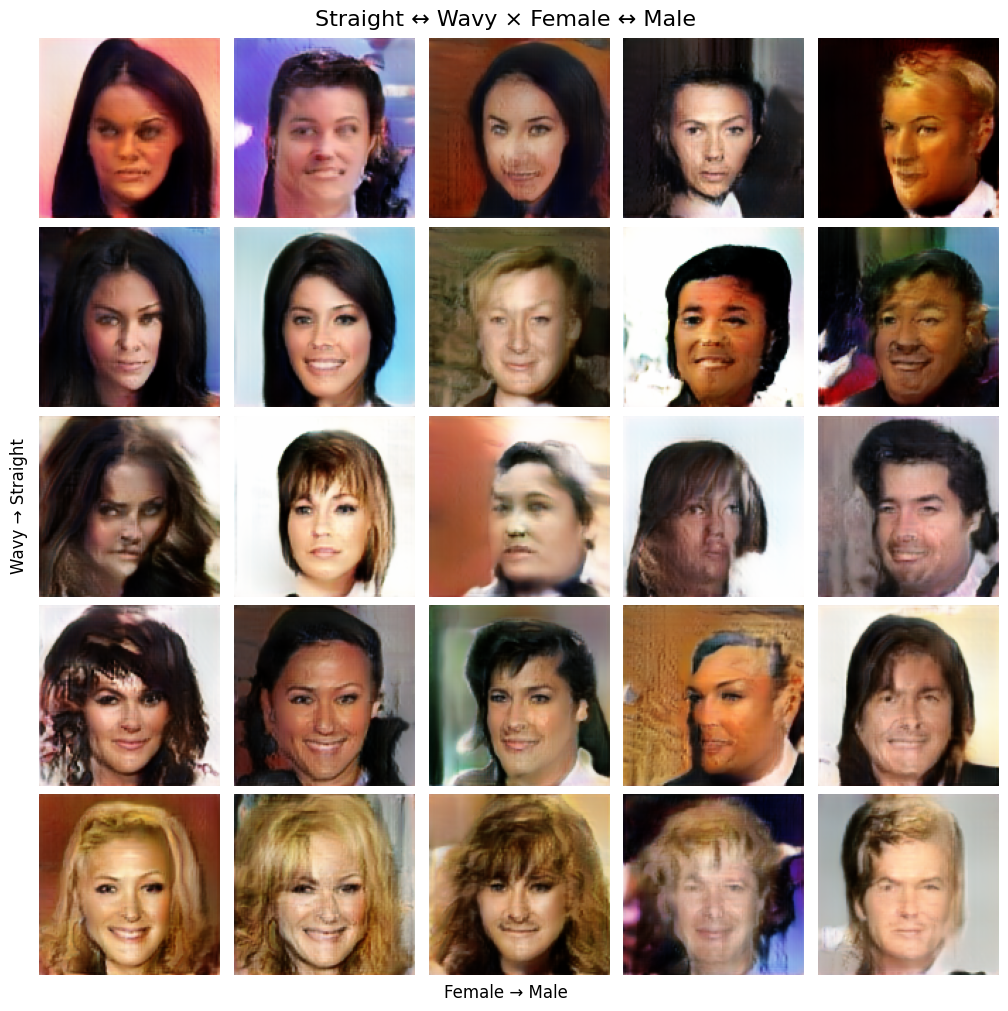

In [ ]:
import torch
import matplotlib.pyplot as plt
from mylib.data_io import to_sigmoid_image

# ── 前処理はそのまま ──
num_hair, num_gender = 5, 5
total = num_hair * num_gender
Z = torch.randn(total, N, device=DEVICE)
hair = torch.linspace(0.0, 1.0, steps=num_hair, device=DEVICE)    # Straight→Wavy
gender = torch.linspace(0.0, 1.0, steps=num_gender, device=DEVICE)  # Female→Male
H, G = torch.meshgrid(hair, gender, indexing='ij')
h_vec = H.reshape(-1)
g_vec = G.reshape(-1)
L = torch.stack([1.0 - h_vec, h_vec, g_vec], dim=1)

# ── 生成 ──
with torch.inference_mode():
    Y = gen_model(Z, L)             # (25, C, H, W)
    Y = to_sigmoid_image(Y)         # [0,1] に正規化

# ── 描画 ──
fig, axes = plt.subplots(num_hair, num_gender, 
                         figsize=(num_gender*2, num_hair*2),
                         constrained_layout=True)

for idx, ax in enumerate(axes.flat):
    img = Y[idx].cpu().detach().permute(1, 2, 0)
    ax.imshow(img)
    ax.axis('off')  # 軸目盛りは非表示

# タイトルと軸ラベル（軸目盛りは非表示のまま「方向指示語」だけ追加）
fig.suptitle('Straight ↔ Wavy × Female ↔ Male', fontsize=16)
fig.supxlabel('Female → Male', fontsize=12)
fig.supylabel('Wavy → Straight', fontsize=12)

plt.show()